# **Regresión lineal y principios de machine learning**

Este notebook tiene como objetivo presentar de al estudiante principios de la regresión lineal de modo que se puedan observar principios de aprendizaje de máquina (machine learning) en tareas supervisadas y contrastarlo con la evaluación estadística clásica de una regresión

##**Business understanding**

Uno de los elementos claves de cualquier estrategia empresarial es movilizar los recursos hasta volverlos capacidades que permitan tener ventajas competitivas en el entorno de industria. Ejemplos de esas ventajas pueden ser un mejor precio (vía reducción de costos) o un producto de mayor calidad (vía diseño de producto/proceso). Es por ello que la administración de operaciones es un medio clave para lograr ventajas competitivas, o como mínimo, mantener a la empresa en niveles competitivos dentro de la industria.

El caso de ejemplo implica conocer el desempeño de un producto bajo diversas condiciones de operación real. El producto es un rastreador de objetos cuya funcionalidad depende (en parte) de la red móvil. El fabricante tiene capacidad de intervención en dicha red móvil.

Lo que se desea predecir es la respuesta del dispositivo rastreador bajo un conjunto de condiciones reales que permitan generar estrategias para que dicha respuesta sea la ideal bajo múltiples condiciones del cliente (particularmente condiciones de conexión y tiempo de uso del producto), bien sea modificando el producto, el servicio, o la red móvil.

In [1]:
install.packages("corrplot")
install.packages("lmtest")
install.packages("MASS")
install.packages("leaps")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(corrplot)
library(lmtest)
library(MASS)
library(leaps)

corrplot 0.92 loaded

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




*Veamos el archivo:*

In [3]:
regtecnica<-read.csv("regtecnica.csv", header=TRUE, sep=";", dec=",")

str(regtecnica)

'data.frame':	99 obs. of  7 variables:
 $ potenciaresp : num  590 464 729 435 464 ...
 $ distancianodo: num  0.064 0.119 0.005 0.014 0.043 0.123 0.029 0.14 0.06 0.13 ...
 $ potencianodo : num  2.13 1.35 1.66 0.43 1.21 0.53 2.15 2.47 1.67 3.75 ...
 $ trafico      : int  500 3020 2502 4444 3132 2162 4352 1202 4776 2348 ...
 $ tiempo       : int  125 312 243 70 261 165 383 357 163 175 ...
 $ picovalle    : int  1 1 1 1 1 0 1 1 0 0 ...
 $ densidad     : num  1.46 5.27 2.02 6.08 2.08 3.56 9.15 1.66 9.86 3.29 ...


La variable dependiente (o de respuesta) es la potencia de respuesta del dispositivo (potenciaresp). Las demás variables son posibles predictoras (variables independientes) e incluyen

1-la distancia al nodo de repetición más cercano (distancianodo)

2-La potencia del nodo de repetición más cercano (potencianodo)

3-El número de señales que el nodo procesa en ese momento (trafico)

4-El número de días desde que está en uso el dispositivo (tiempo)

5-Si es hora de alto tráfico (0) o bajo tráfico (1)- (picovalle)

6- La cantidad de nodos repetidores por kilómetro cuadrado (densidad)

##**Aproximaciones al problema de predicción: estadística clásica vs. machine learning**

Hay dos aproximaciones usuales a un problema de predicción: una aproximación estadística clásica y una aproximación de aprendizaje de máquina.

En la aproximación estadística clásica deben variarse las condiciones (valores) de las variables independientes de manera experimental para observar sus efectos en la variable de respuesta. Dichas variables independientes deben escogerse idealmente bajo un fundamento teórico. En esta aproximación, el cumplimiento de un conjunto de supuestos estadísticos es fundamental para demostrar la validez de la aproximación y su posible generalización a nuevos casos.
La capacidad explicativa del fenómeno es de alta relevancia, superior a la de su capacidad predictiva. Los resultados pueden interpretarse con total tranquilidad como resultados de causa y efecto si se ha realizado de manera experimental.

En la aproximación de machine learning con frecuencia la variación de los valores de las variables independientes no se han dado experimentalmente, sino en condiciones naturales del fenómeno. Dichas variables independientes se escogen ante todo dependiendo de su disponibilidad, por lo que podría haber factores/variables ocultas o intermedias. El cumplimiento/violación de los suspuestos estadísticos no invalida el modelo, sino que da pistas sobre posibles mejoramientos. La validación/generalización del modelo se da fundamentalmente por su capacidad predictiva en datos que no hacían parte de los que permitieron generar el modelo (separación de las bases de entrenamiento y validación). La capacidad predictiva tiene una mayor importancia que la explicativa.

###**Bases de entrenamiento y validación**

Al momento de generar bases de entrenamiento y validación, la primera y más básica aproximación es dividir la base de datos en dos: entrenamiento y validación. No existe un criterio único y definido para saber qué porcentaje de la base de datos debe entregarse a entrenamiento y cuál a validación. De manera empírica, con frecuencia se usa el 80% de los datos para la base de entrenamiento y el 20% de los datos para la base de validación.

In [ ]:
set.seed(920203) #se deja alguna semilla para que el muestreo sea replicable
#aquí se define el tamaño de la muestra, en este caso entrenamiento tendrá el 80% de los casos
sample <- sample.int(nrow(regtecnica), floor(.8*nrow(regtecnica)))
regtecnica.train <- regtecnica[sample, ]
regtecnica.test <- regtecnica[-sample, ]

##**Aproximación estadística clásica**

Vamos a crear dos modelos lineales clásicos. En ellos, las variables independientes se definen de antemano, es decir, son preespecificadas.

###**Entendimiento de datos**

Primero vamos a observar la correlación entre los datos

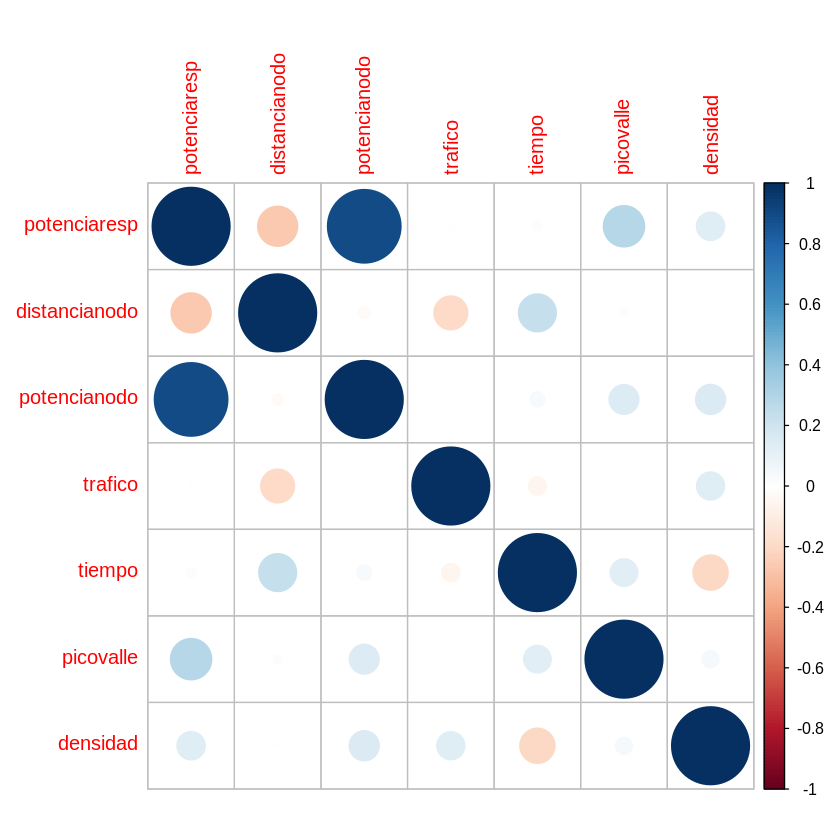

In [ ]:
matrizcor<-cor(regtecnica.train)
corrplot(matrizcor)

Se pueden observar algunas asociaciones con la variable dependiente. Así mismo debe buscarse que las variables independientes no tengan alta correlación entre sí (multicolinealidad) porque puede generar inestabilidad en el modelo (esto es, cambios bruscos en los coeficientes con la inclusión/exclusión de datos).
Para los modelos estadísticos clásicos, la capacidad explicativa puede verse reducida por la razón anterior, y por cambios de signo en los coeficientes que hacen los resultados no interpretables.

###**Realización de modelos**

Un posible primer modelo implica que la potencia del nodo más cercano y la hora pico/valle son posibles predictores.
Un segundo modelo va a contener todas las variables que fueron recogidas, puesto que todas tenían algun tipo de sustento empírico y teórico.

In [ ]:
#CREANDO MODELOS BASICOS
#un modelo con variables elegidas (preespecificado)
modelo0<- lm(potenciaresp ~ potencianodo + picovalle,data=regtecnica.train)
# un modelo con todas las variables (preespecificado)
modelo1<- lm(potenciaresp ~.,data=regtecnica.train)

###**Valoración de modelos**

Una vez obtenidos los modelos se pasa a revisar sus métricas de ajuste (calidad) y el cumplimiento de supuestos.

In [ ]:
#pruebas de hipótesis y dos métricas
summary(modelo0)


Call:
lm(formula = potenciaresp ~ potencianodo + picovalle, data = regtecnica.train)

Residuals:
   Min     1Q Median     3Q    Max 
-81.85 -35.85 -13.97   6.11 372.69 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    285.56      18.54  15.401  < 2e-16 ***
potencianodo   104.55       5.96  17.542  < 2e-16 ***
picovalle       52.60      16.95   3.103  0.00269 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 74.03 on 76 degrees of freedom
Multiple R-squared:  0.8177,	Adjusted R-squared:  0.8129 
F-statistic: 170.4 on 2 and 76 DF,  p-value: < 2.2e-16


In [ ]:
summary(modelo1)


Call:
lm(formula = potenciaresp ~ ., data = regtecnica.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-100.398  -28.257   -9.729   15.538  307.412 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.735e+02  2.896e+01  12.899  < 2e-16 ***
distancianodo -7.301e+02  1.262e+02  -5.785 1.74e-07 ***
potencianodo   1.039e+02  5.048e+00  20.592  < 2e-16 ***
trafico       -4.995e-03  4.922e-03  -1.015 0.313590    
tiempo        -1.916e-02  6.343e-02  -0.302 0.763454    
picovalle      5.253e+01  1.432e+01   3.669 0.000464 ***
densidad       4.266e-02  2.443e+00   0.017 0.986113    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61.9 on 72 degrees of freedom
Multiple R-squared:  0.8793,	Adjusted R-squared:  0.8692 
F-statistic: 87.38 on 6 and 72 DF,  p-value: < 2.2e-16


En este resumen, se observan las primeras y más básicas evaluaciones del modelo de regresión. Tenemos dos pruebas de hipótesis y dos métricas de ajuste.

Miremos primero la prueba de hipótesis F (F statistics). Se trata de una prueba básica en la que, si la regresión explica un poco más que el error (el modelo explica más que el azar), el valor p será pequeño. A menos que las variables independientes tengan muy baja asociación con la dependiente, esta prueba se verificará y nos dirá que el modelo tiene un mínimo nivel de validez predictiva.

Más interesantes son las pruebas de hipótesis t individuales para cada variable independiente (Pr > |t|), en las que se prueba si cada coeficiente es o no diferente de cero, lo que da una idea de si la inclusión de cada una de las variables valió la pena en el modelo (el asunto es un poco más complejo porque las interacciones y el tipo de relación cuentan: ver feature selection y feature engineering más adelante).

En nuestro primer modelo ambas variables tienen coeficientes significativos, pero en el modelo con todas las variables, tres de ellas (tráfico, tiempo y densidad) no tienen un valor p que permita rechazar la idea de que sus coeficientes sean cero (en palabras llanas, esas variables no parecen aportar o ser importantes para explicar/predecir la variable dependiente). También podemos obtener intervalos de confianza para los coeficientes:

In [ ]:
#Intervalos de confianza
confint(modelo0, level=0.95)

,2.5 %,97.5 %
(Intercept),248.63212,322.4921
potencianodo,92.68078,116.4222
picovalle,18.83328,86.3655


Las dos métricas que se presentan son: el r2 (ajustado) y el error estándar promedio de los residuales (error residual).
El r2 nos indica el porcentaje de la variabilidad de la variable dependiente (la respuesta del dispositivo) que las variables dependientes logran explicar. Dado que se trata de un modelo que incluye múltiples variables independientes, es indispensable utilizar como medio de comparación el r2 ajustado (Adjusted R-squared), el cual es un primer intento por penalizar el sobreajuste u overfitting (más sobre esto en la sección de overfitting). Nuestro modelo de dos variables explica el 79.9% de la variabilidad, mientras que el modelo con todas las variables cubre el 85.8% de la variabilidad.

El error residual nos dice a cuánto asciende, en promedio, la variabilidad que no se ha logrado explicar, en dimensiones de la variable dependiente. En ese sentido, es muy útil para valorar desde el negocio y la operación si el modelo es viable. Nuestros modelos básico y completo tienen errores residuales de 72.52 y 62.37 milivatios, esto es, cuando hagamos una predicción para un caso nuevo podemos esperar un error de este tamaño en la predicción. Que este error sea aceptable/manejable o no depende del contexto del negocio. En operaciones y finanzas estos valores pueden ayudar a calcular márgenes de contingencia o tolerancia que mejoren la planeación y permitan estar preparados para asumir o absorber estos errores. La regla clásica (si se cumplen los supuestos, particularmente el de normalidad de variables) es planear una contingencia de dos veces este error hacia arriba o hacia abajo para cubrir el 95% de los riesgos de error.

Resumiendo la comparación, el modelo completo tiene mejores métricas que el modelo básico, pero algunos de sus coeficientes no son significativos, lo que lleva a sospechar que incluir todas las variables no es lo adecuado. Adicionalmente, ambas métricas presentadas tienen riesgo de estar infladas para el modelo completo debido al overfitting.

Para revisar el cumplimiento de supuestos, es importante recordar cuáles son los supuestos básicos:
a) Los residuales se distribuyen normalmente con media cero
b) la varianza de los residuales es constante (homocedasticidad)
c) los residuos no están correlacionados

Estos supuestos son buenos indicios (pero no pruebas definitivas) de que los residuos son ruido blanco , es decir, no hay ningún patrón residual en ellos que nos permita mejorar la explicación que hemos logrado con nuestro modelo actual.

Primero, presentaremos 4 gráficos de diagnóstico de residuos:

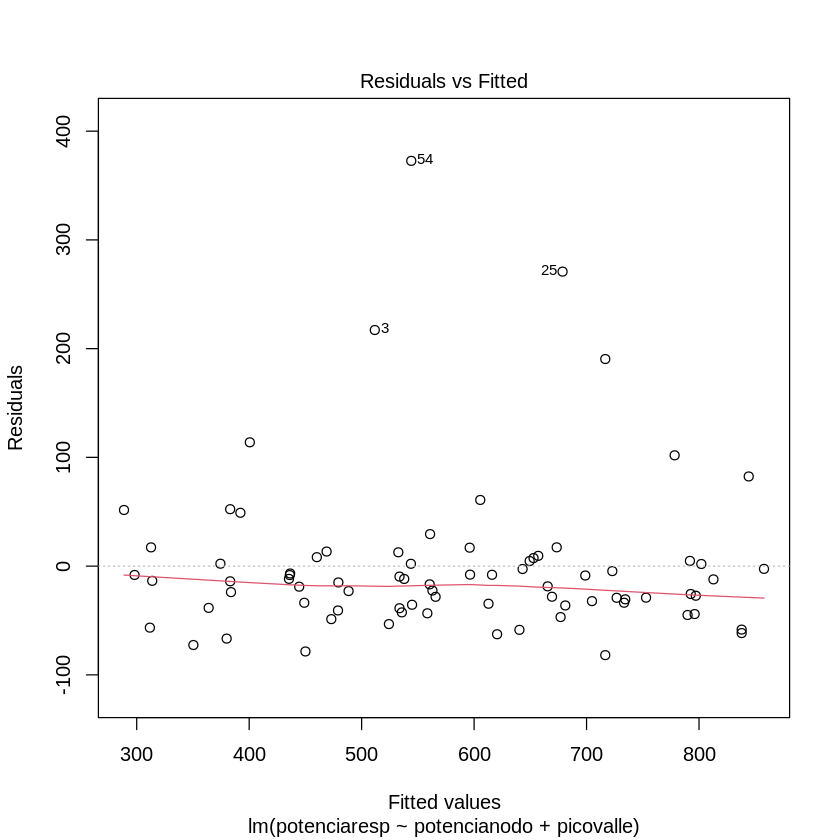

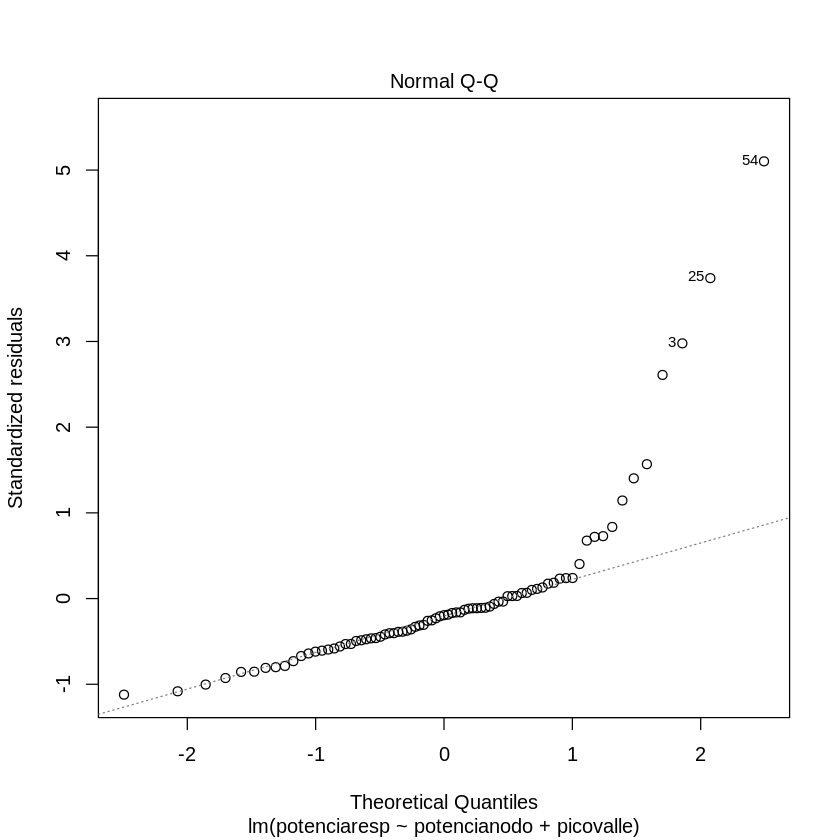

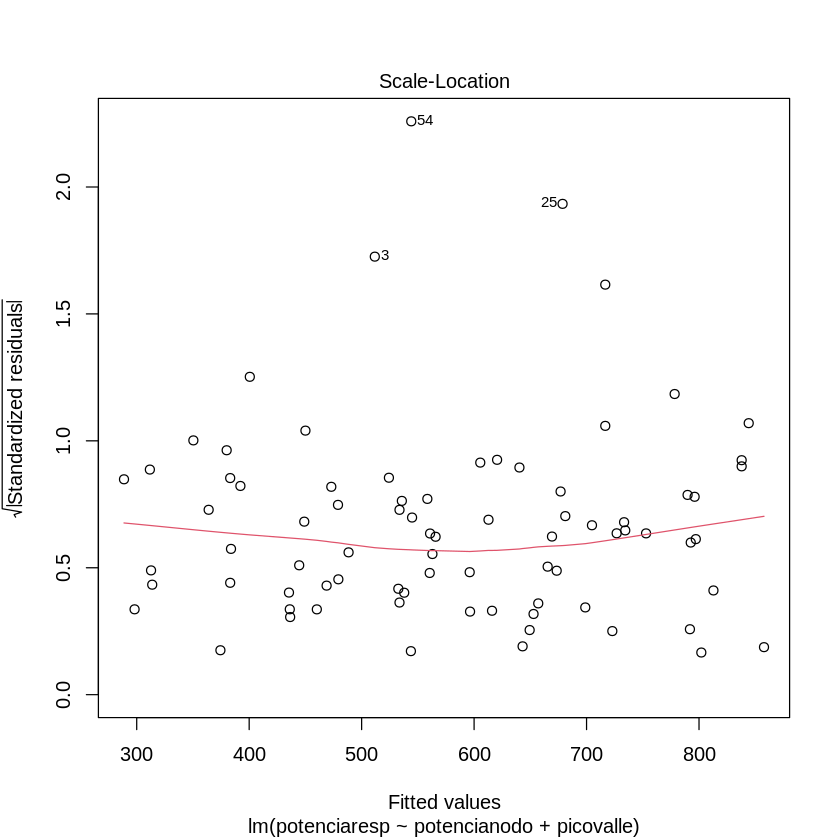

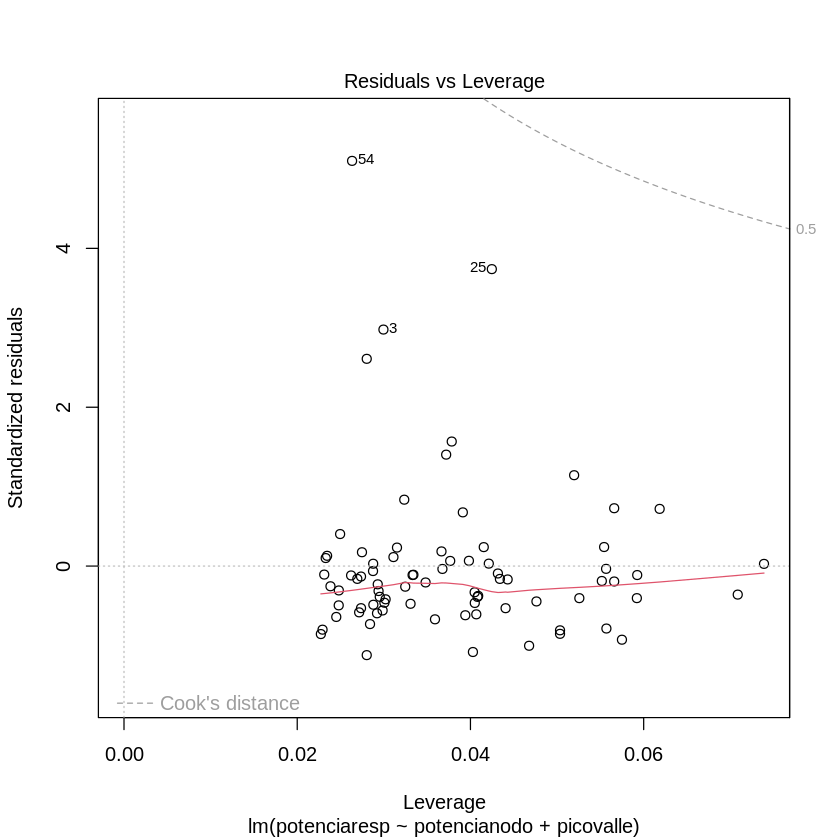

In [ ]:
#layout(matrix(c(1,2,3,4),2,2)) # opcional 4 graficos/pagina
plot(modelo0)

El primer y tercer gráfico muestran las predicciones en el eje x contra los residuos (simples en el primer gráfico o la raíz de los estandarizados en el tercero). En ambos, el objetivo es detectar atípicos y algún tipo de patrón visible. El gráfico marca los valores que se podrían considerar atípicos (los casos 3, 25 y 54) por estar encima o debajo de las 3 desviaciones estándar. Los patrones si deben ser observados por el analista. Un patrón clásico es la forma de embudo, que implica bajos errores en predicciones bajas y altos errores en predicciones altas, un signo claro de que la variabilidad no es constante y estamos en presencia de no homocedasticidad. Los gráficos presentados no parecen tener algun patrón adicional.

El segundo gráfico es un gráfico Q-Q para comparar la distribución de los residuales contra la curva normal. En la medida en que los cuantiles teóricos no se corresponden con los valores de los residuos encontrados, particularmente cuando hablamos de residuos positivos altos (parte derecha/arriba de la gráfica) entonces muy probablemente nuestor modelo no cumpla el supuesto de normalidad.

Por último, el cuarto gráfico chequea la presencia de puntos de influencia, casos que cambian significativamente el resultado de la regresión. Valores más allá de la curva roja (largas distancias de Cook) serían puntos de influencia que invitan a obtener más casos de combinaciones cercanas de variables dependientes para saber si el modelo actual es válido como está o simplemente se ve influenciado y dominado por esos puntos en regiones “escasas” de puntos. No parece ser el caso para nuestro modelo básico.

Por último, chequeemos la autocorrelación de residuos:

In [ ]:
dwtest(modelo0)


	Durbin-Watson test

data:  modelo0
DW = 2.2031, p-value = 0.8178
alternative hypothesis: true autocorrelation is greater than 0


In [ ]:
dwtest(modelo1)


	Durbin-Watson test

data:  modelo1
DW = 2.0992, p-value = 0.6707
alternative hypothesis: true autocorrelation is greater than 0


Esta prueba de hipótesis prueba la autocorrelación de los datos con su dato inmediatamente anterior. Rechazar la hipótesis nula implica una sospecha de autocorrelación en los residuos, esto es, el orden en que se presentan los datos permite explicar parcialmente patrones en los residuos. Esto se presenta con frecuencia en datos en los que el factor tiempo u orden de recolección de los datos tiene algun efecto, (!o cuando la base de datos ha sido ordenada artificialmente también puede ocurrir!) En nuestro caso no se presentan valores p pequeños, por lo que descartamos autocorrelación de residuos.

En resumen, nuestro modelo básico presenta valores atípicos, particularmente residuos positivos altos en los que nuestra predicción está muy por debajo del valor real, lo que conlleva también a la violación del supuesto de normalidad. Si se obtienen los diagnósticos de supuestos para el modelo completo, la situación es altamente similar.

###**Conclusión**

Desde un punto de vista estadístico clásico tanto el modelo básico como el modelo completo (parte de cuyos coeficientes además no son significativos) deben ser revisados y no son explicativos del fenómeno, aunque sus ajustes son relativamente buenos. El modelo está incompleto y deben recogerse nuevos datos y trabajar más profundamente en la teoría.

##**Aproximación de aprendizaje de máquina (machine learning)**

Desde esta aproximación, lo que se busca es sacar el mejor provecho posible a los datos existentes (aprender de ellos) de modo que la capacidad predictiva sea máxima, aunque la explicabilidad teórica y la robustez estadística de los resultados como modelo del mundo no sean las ideales.

###**Feature selection & overfitting**

Si contamos con un conjunto específico de variables, ¿cómo seleccionar aquellas que puedan darnos el mejor poder predictivo/explicativo?. El proceso para responder a esta pregunta se conoce como feature selection o selección de variables.

El objetivo (múltiple) de la selección de variables es obtener el mínimo número de variables que me den la máxima capacidad de predicción generalizada a datos nuevos o frescos. En palabras de Einstein, un modelo debe ser “tan simple como sea posible, pero no simplista”

Una razón fundamental para tratar de reducir el número de variables es eminentemente práctica, menos variables implican
a) Menos gasto en la recolección adecuada y precisa de datos
b) Menos gasto computacional y por tanto, mayor velocidad de implementación
c) Mayor capacidad de realizar explicaciones teóricas

Una segunda razón poderosa para ajustar el número de variables es el riesgo de ocurrencia de un fenómeno denominado sobreajuste u overfitting.

Overfitting es, literalmente, aprender para el examen (base de entrenamiento) sin aprender para la vida (los datos frescos).

Siendo más precisos, mientras más parámetros se incluyan en un modelo, más probable es que el modelo se ajuste perfectamente a los datos desde los que aprendió y pierda capacidad de generalizar en datos nuevos.

En el caso de la regresión, cualquier variable que se incluya como posible predictora (independiente) va a generar un aumento en el r2. De ese modo, si tenemos n casos y usamos como variable predictora un polinomio de grado n+1 podemos ajustar la predicción perfectamente (r2=1) a los datos de los que se está aprendiendo.
Es por eso que el r2 no es una métrica adecuada cuando se usa la aproximación de machine learning en una regresión. Una primera mejora es el uso del r2 ajustado, el cual penaliza la métrica por el número de parámetros (variables) que se utilizaron.

Una mejor opción es la utilización del criterio de información de Aikake (AIC), el cual también penaliza por el número de parámetros de una manera más formal, basado en la teoría de la información. Mientras menor sea el valor del AIC, mejor es el modelo en comparación relativa con los otros modelos candidatos.
Veamos como funciona eso en los modelos que ya hemos creado.

In [ ]:
#obteniendo el AIC
AIC(modelo0)

[1] 909.2442

In [ ]:
AIC(modelo1)

[1] 884.6893

Así comparados, nuestro modelo completo es mejor que el modelo con sólo dos variables (reducido).

Sin embargo, el mecanismo más utilizado par evaluar la capacidad predictiva de un modelo es el uso de una métrica de predicción en datos frescos, como explicamos al principio. Es por eso que separamos dos bases: una de entrenamiento y otra de validación.

Ahora vamos a hacer predicciones basadas en cada uno de nuestros modelos, y compararlas a partir de la raíz cuadrática media del error (RMSE)

In [ ]:
#PREDICCIONES
#hacer predicciones
pred0<-predict(modelo0, regtecnica.test, se.fit=TRUE)

pred1<-predict(modelo1, regtecnica.test, se.fit=TRUE)

RMSE0<-sqrt(mean((pred0$fit-regtecnica.test$potenciaresp)^2))
RMSE1<-sqrt(mean((pred1$fit-regtecnica.test$potenciaresp)^2))
RMSE0

[1] 34.10268

In [ ]:
RMSE1

[1] 40.36593

Bajo esta métrica, nuestro modelo completo está obteniendo mejores predicciones que el modelo reducido (una ganancia relativa de 6.44 milivatios en el error).

Pero, ¿será que nuestro modelo básico sufre de un pobre ajuste, y es posible conseguir un modelo que tenga mejores predicciones que el modelo completo sin utilizar todas las variables independientes?

Para saber eso, es necesario utilizar métodos de selección de variables en regresión.

###**Feature selection en regression**

Hay por lo menos tres métodos de selección de variables en regresión:

Pasos sucesivos (stepwise)

Mejores subconjuntos (best subsets)

Uso de componentes principales

**Stepwise**

Este método se basa en la idea de ir eligiendo secuencialmente las variables que deben incluirse o retirarse del modelo de acuerdo a un criterio. En el caso de R, el criterio es efectivamente la reducción en AIC. Se busca primero la variable que reduzca más el AIC frente a un modelo sin predictores; una vez incluida, se evalúa si la inclusión/exclusión de alguna variable adicional reduce el AIC, y de ser así, se incluye. El proceso se detiene cuando ninguna inclusión/exclusión de variables disminuye el AIC.

Para poder ejecutarlo en R, es necesario haber creado primero el modelo completo. Todos los pasos secuenciasles son visibles en el resultado.

In [ ]:
#Feature selection
##stepwise
modelostep<- step(modelo1,direction="both")

Start:  AIC=658.5
potenciaresp ~ distancianodo + potencianodo + trafico + tiempo + 
    picovalle + densidad

                Df Sum of Sq     RSS    AIC
- densidad       1         1  275858 656.50
- tiempo         1       350  276207 656.60
- trafico        1      3946  279803 657.62
<none>                        275857 658.50
- picovalle      1     51564  327421 670.03
- distancianodo  1    128213  404070 686.65
- potencianodo   1   1624609 1900466 808.96

Step:  AIC=656.5
potenciaresp ~ distancianodo + potencianodo + trafico + tiempo + 
    picovalle

                Df Sum of Sq     RSS    AIC
- tiempo         1       379  276237 654.61
- trafico        1      4002  279861 655.64
<none>                        275858 656.50
+ densidad       1         1  275857 658.50
- picovalle      1     51765  327623 668.08
- distancianodo  1    129180  405038 684.84
- potencianodo   1   1665623 1941481 808.65

Step:  AIC=654.61
potenciaresp ~ distancianodo + potencianodo + trafico + picovalle

 

In [ ]:
summary(modelostep)


Call:
lm(formula = potenciaresp ~ distancianodo + potencianodo + picovalle, 
    data = regtecnica.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-108.214  -29.160   -9.311   14.887  307.371 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    354.934     19.138  18.546  < 2e-16 ***
distancianodo -715.542    118.456  -6.041 5.47e-08 ***
potencianodo   103.926      4.922  21.114  < 2e-16 ***
picovalle       51.927     13.998   3.710 0.000396 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61.12 on 75 degrees of freedom
Multiple R-squared:  0.8774,	Adjusted R-squared:  0.8724 
F-statistic: 178.8 on 3 and 75 DF,  p-value: < 2.2e-16


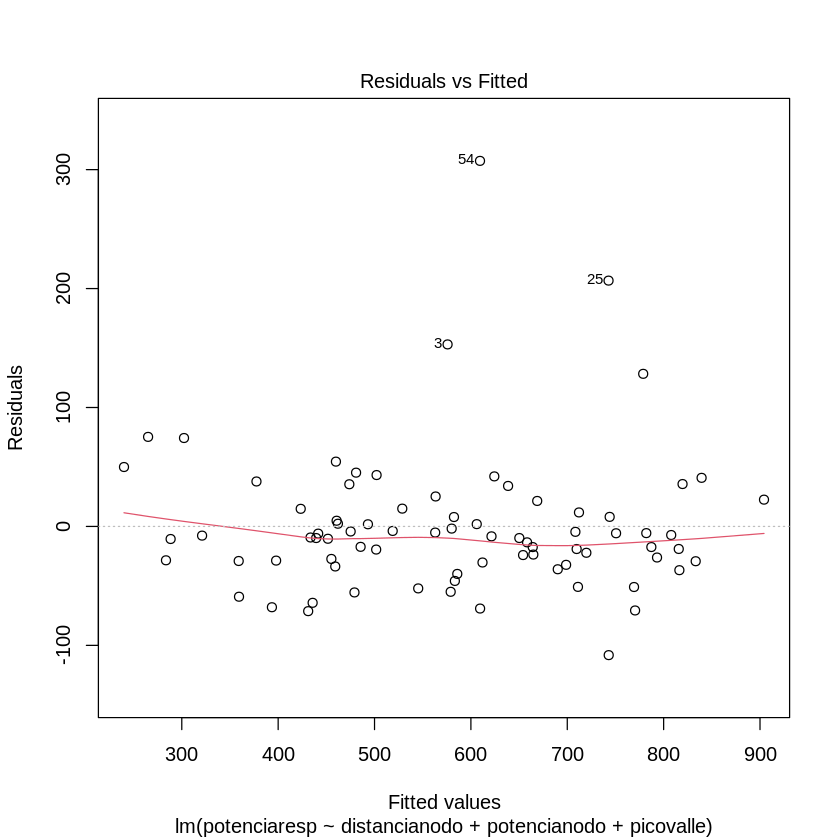

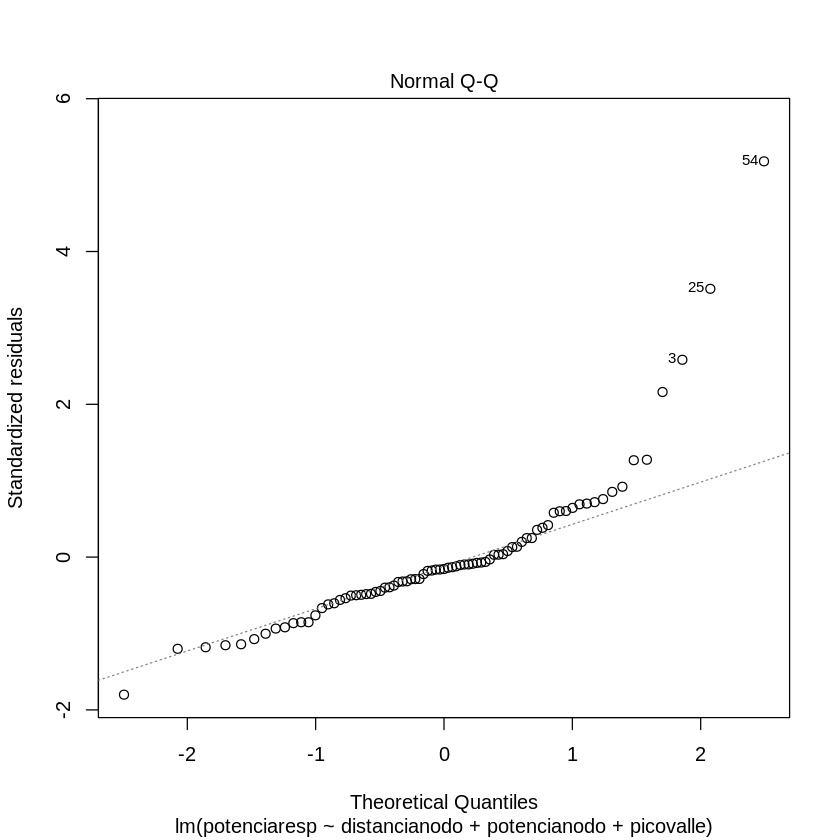

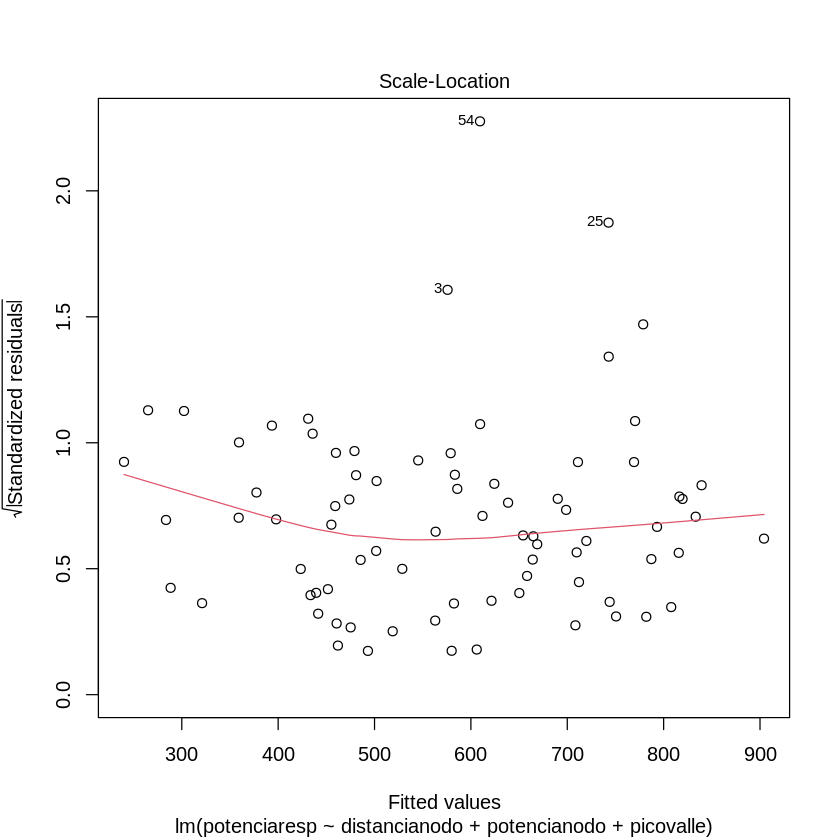

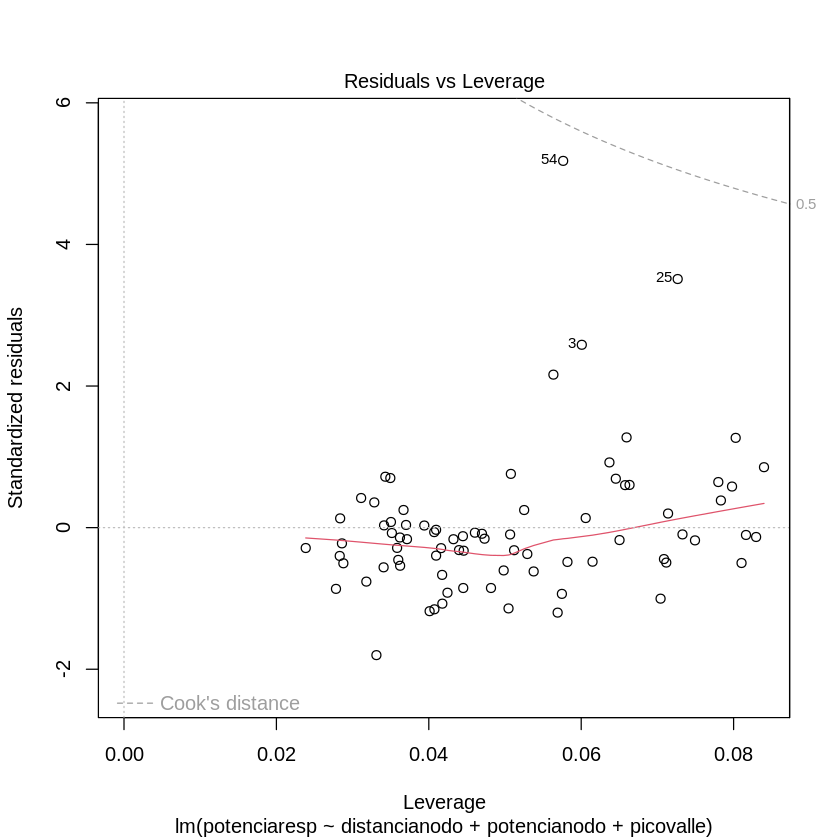

In [ ]:
plot(modelostep)

In [ ]:
dwtest(modelostep)


	Durbin-Watson test

data:  modelostep
DW = 2.1304, p-value = 0.7215
alternative hypothesis: true autocorrelation is greater than 0


El r2 y el error residual son muy cercanos al del modelo completo, con la ventaja de una mayor parsimonia (esto es, menos variables). Sin embargo, la violación de los supuestos se sigue presentando, con los atípicos presentes, los cuales corren alto riesgo de influenciar el modelo por su leverage.

**Best subsets**

Dado un número de variables máximo n, la técnica de mejores subconjuntos busca todos los subconjuntos de tamaño k donde k<=n. Este método no trabaja secuencialmente, sino que hace todos los modelos posibles para cada tamaño n. Como métrica de escogencia utiliza algo conocido como el Cp de Mallows, el cual tiene una fuerte relación con el AIC.

In [ ]:
#nbest (n?mero de modelos por cada k) es por defecto 1 y nvmax es por defecto 8 (k m?ximo)
modelsub<-regsubsets(potenciaresp~.,data=regtecnica.train, nbest=1, nvmax=6, method = "exhaustive") 
summary(modelsub)

Subset selection object
Call: regsubsets.formula(potenciaresp ~ ., data = regtecnica.train, 
    nbest = 1, nvmax = 6, method = "exhaustive")
6 Variables  (and intercept)
              Forced in Forced out
distancianodo     FALSE      FALSE
potencianodo      FALSE      FALSE
trafico           FALSE      FALSE
tiempo            FALSE      FALSE
picovalle         FALSE      FALSE
densidad          FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         distancianodo potencianodo trafico tiempo picovalle densidad
1  ( 1 ) " "           "*"          " "     " "    " "       " "     
2  ( 1 ) "*"           "*"          " "     " "    " "       " "     
3  ( 1 ) "*"           "*"          " "     " "    "*"       " "     
4  ( 1 ) "*"           "*"          "*"     " "    "*"       " "     
5  ( 1 ) "*"           "*"          "*"     "*"    "*"       " "     
6  ( 1 ) "*"           "*"          "*"     "*"    "*"       "*"     

Los asteriscos marcan si la variable está incluida o no en el modelo, y cada línea marca un k.

Notemos que el mejor subconjunto de 3 es igual al modelo stepwise. No necesariamente eso ocurre: stepwise, por su naturaleza secuencial, no evalúa todas las opciones posibles, sino solo un subconjunto de ellas.

Una vez se han generado los modelos, podemos ver algunas características de ellos:

In [ ]:
#obtener r2 ajustado
summary(modelsub)$adjr2

[1] 0.7919227 0.8510279 0.8724457 0.8725549 0.8709861 0.8691948

In [ ]:
#obtener el cp
summary(modelsub)$cp

[1] 47.487130 13.555252  2.136035  3.099111  5.000305  7.000000

In [ ]:
#obtener el BIC (medida similar al AIC)
summary(modelsub)$bic

[1] -116.2983 -139.3594 -148.2985 -145.0571 -140.7960 -136.4269

Observe que el r2 ajustado disminuye desde el modelo con 5 variables, y que tanto Cp como BIC son consistentes con el AIC, y empeoran en la medida en que se superan las 3 variables, por lo que el modelo obtenido con stepwise es probablemente nuestra mejor apuesta.

Miremos como se desempeña en la base de validación:

In [ ]:
#Desempe?o en la base de validaci?n
predstep<-predict(modelostep, regtecnica.test, se.fit=TRUE)
RMSEstep<-sqrt(mean((predstep$fit-regtecnica.test$potenciaresp)^2))
RMSE0

[1] 34.10268

In [ ]:
RMSE1

[1] 40.36593

In [ ]:
RMSEstep

[1] 38.11895

Nuestro modelo stepwise es el de mejor desempeño de los modelos generados hasta ahora, pero aún presenta esos extraños atípicos en los diagnósticos que invitan a un análisis más detallado.

###**El problema del feature engineering**

Vamos a explorar un poco más en detalle esos 3 valores atípicos que se presentan. En particular, vamos a comparar la media en cada variable con la media general.

In [ ]:
#extraer atipicos
atipicos<-c("3","25","54")
veratipicos<-regtecnica.train[atipicos,]
#obtener su media en todas las variables
atiptc<-apply(veratipicos,2,mean)
#obtener la media general y comparar
todostc<-apply(regtecnica.train,2,mean)
comparar<-as.data.frame(cbind(atiptc,todostc))
comparar

,atiptc,todostc
,<dbl>,<dbl>
potenciaresp,865.0663333,5.793468e+02
distancianodo,0.0040000,9.421519e-02
potencianodo,2.4633333,2.529747e+00
trafico,3103.3333333,2.673570e+03
tiempo,198.6666667,2.329114e+02
picovalle,0.6666667,5.569620e-01
densidad,3.4933333,5.345063e+00


Al hacer esta comparación resulta evidente que nuestros atípicos tienen más baja la variable de respuesta que el promedio, y muy baja la distancia al nodo frente al promedio general.

Si exploramos esto un poco más, podemos graficar entonces nuestros residuos contra esa distancia al nodo más cercano:

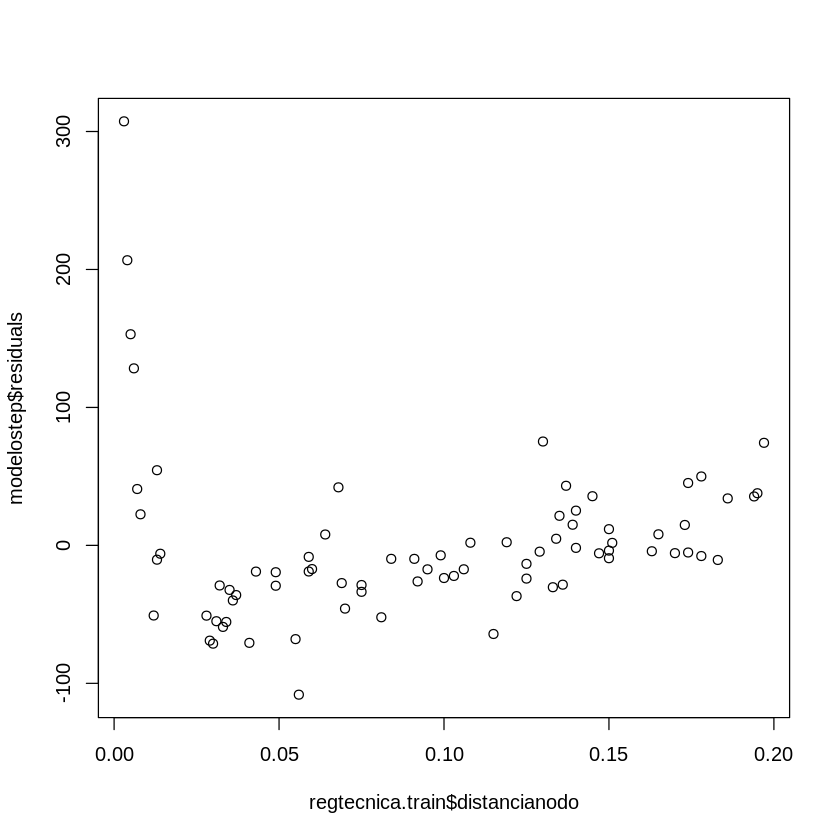

In [ ]:
plot(regtecnica.train$distancianodo,modelostep$residuals)

Se puede observar claramente que los residuales más altos corresponden a valores bajos de la distancia al nodo más cercano. ¿cómo explicarlo y usarlo?

Hasta ahora hemos hecho dos suposiciones tácitas: que las variables independientes presentes en la base de datos son las adecuadas para explicar la variable dependiente, y que la forma funcional de relación entre las variables independientes y dependiente estaba definida.

La primera suposición es comparable a lo mencionado en clustering con respecto al teorema del patito feo y a lo que los modelos estadísticos clásicos mencionan: la escogencia de las variables que están en la base de datos no es neutra frente al modelo, y lo ideal es tener pistas o certidumbres de que, en el dominio del problema, las variables son relevantes.

La segunda suposición implica que consideramos que la relación de las variables independientes con la dependiente es lineal. La gráfica que hicimos sugiere que la relación con la distancia al nodo no es lineal, por lo menos para todos los posibles valores de distancia, y particularmente en los más bajos.

feature enginnering es la transformación y/o identificación de variables relevantes que pueden ser útiles para el modelo. Implica derivar variables desde las variables originales o conseguir nuevas variables. Generalmente requiere tener dominio del conocimiento o una aproximación teórica al fenómeno, porque de otro modo la búsqueda es ciega y las posibles transformaciones infinitas.

En nuestro caso, un dominio de conocimiento físico implica que la relación entre la potencia de una señal entre dos elementos y su distancia es inversa o cuadrática inversa. Vamos a crear esas dos variables, en ambas bases:

In [ ]:
#entrenamiento
regtecnica.train$inverso=(1/regtecnica.train$distancianodo)
regtecnica.train$inverso2=(1/regtecnica.train$distancianodo^2)

#validacion
regtecnica.test$inverso=(1/regtecnica.test$distancianodo)
regtecnica.test$inverso2=(1/regtecnica.test$distancianodo^2)

Y posteriormente, vamos a pedirle al método de pasos sucesivos que nos indique si vale la pena incluirlas:

In [ ]:
modelo2<- lm(potenciaresp ~.,data=regtecnica.train)
modelo2step<-step(modelo2)

Start:  AIC=508.34
potenciaresp ~ distancianodo + potencianodo + trafico + tiempo + 
    picovalle + densidad + inverso + inverso2

                Df Sum of Sq     RSS    AIC
- inverso2       1       232   39426 506.81
- distancianodo  1       470   39665 507.28
<none>                         39195 508.34
- tiempo         1      1284   40479 508.89
- densidad       1      2132   41326 510.52
- trafico        1      8879   48073 522.47
- inverso        1     16769   55963 534.48
- picovalle      1     27979   67173 548.90
- potencianodo   1   1590104 1629298 800.80

Step:  AIC=506.81
potenciaresp ~ distancianodo + potencianodo + trafico + tiempo + 
    picovalle + densidad + inverso

                Df Sum of Sq     RSS    AIC
- distancianodo  1       250   39677 505.31
<none>                         39426 506.81
- tiempo         1      1257   40684 507.29
- densidad       1      2344   41771 509.37
- trafico        1      9259   48685 521.47
- picovalle      1     27761   67188 546.92

In [ ]:
summary(modelo2step)


Call:
lm(formula = potenciaresp ~ potencianodo + trafico + tiempo + 
    picovalle + densidad + inverso, data = regtecnica.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-67.445 -16.103  -1.169  15.494  56.415 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  277.839231  10.336766  26.879  < 2e-16 ***
potencianodo 102.911763   1.914862  53.744  < 2e-16 ***
trafico       -0.007521   0.001858  -4.048 0.000129 ***
tiempo        -0.039981   0.023462  -1.704 0.092681 .  
picovalle     38.698761   5.467021   7.079 7.92e-10 ***
densidad       1.908779   0.930613   2.051 0.043897 *  
inverso        1.261920   0.049074  25.715  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.47 on 72 degrees of freedom
Multiple R-squared:  0.9826,	Adjusted R-squared:  0.9812 
F-statistic:   679 on 6 and 72 DF,  p-value: < 2.2e-16


Observe lo sorprendente de estos resultados: no solo el inverso es seleccionado,sino que su presencia hace que otras variables que habían sido descartadas (trafico y densidad) entran a hacer parte de un modelo cuyo r2 sube a 97.6% y error estándar de residuos baja a 24.59 miliwatios.

Este ejemplo muestra claramente como variables con la relación correcta obtenida desde el dominio del conocimiento pueden mejorar sustancialmente el aprendizaje de máquina.

Veamos ahora los supuestos:

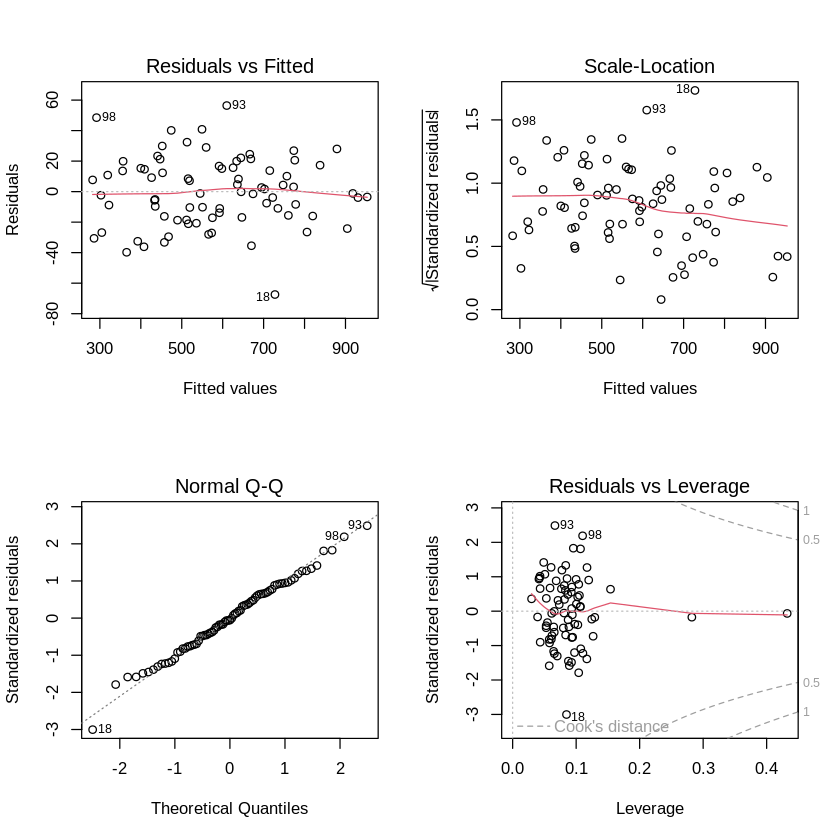

In [ ]:
layout(matrix(c(1,2,3,4),2,2)) # opcional 4 graficos/pagina
plot(modelo2step)

In [ ]:
dwtest(modelo2step)


	Durbin-Watson test

data:  modelo2step
DW = 2.3939, p-value = 0.9625
alternative hypothesis: true autocorrelation is greater than 0


Los problemas de atípicos están bastante disminuidos. Es un modelo que pasa los supuestos de un modelo de regresión, aunque aún hay algunos casos que podrían explorarse.

Finalmente, las predicciones:

In [ ]:
predstep2<-predict(modelo2step, regtecnica.test, se.fit=TRUE)

RMSEstep2<-sqrt(mean((predstep2$fit-regtecnica.test$potenciaresp)^2))
RMSE0

[1] 34.10268

In [ ]:
RMSE1

[1] 40.36593

In [ ]:
RMSEstep

[1] 38.11895

In [ ]:
RMSEstep2

[1] 26.72095

En resumen, la creación de modelos con machine learning implica una fina sintonización de las variables disponibles, evitando el sobreajuste y realizando tanto selección de variables como ingeniería de variables (feature engineering)